# Capstone 4

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import sklearn.metrics
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Topic: Speaking as a DA from a business that wants to perform better compared to others in the same country, and uncover what they're doing better that we can potentially adopt. I'd also like to make a prediction on products sold based on seller gender, country, # of followers, etc!

The data was scraped from a successful online C2C fashion store with over 9M registered users. The store was first launched in Europe around 2009 then expanded worldwide. The data source on Kaggle did not mention the fashion store by name, but my research tells me it's Vestiaire Collective.

Visitors vs Users:
Visitors do not appear in this dataset. Only registered users are included. "Visitors" cannot purchase an article but can view the catalog.

# Loading and cleaning datasets

In [2]:
# Countries in each dataset written in French. When inspecting on Excel, noticed encryption/accents. Saving to UTF-8,
# and using IFERROR + VLOOKUP to translate country names

In [3]:
# Dealing with encrypted and accented characters:
# Open Excel
# Click “File” and “New”
# Click on the “Data” tab
# Click “From Text” and select the CSV file
# Select “Delimited”
# For “File origin”, select “65001 : Unicode (UTF-8)”
# Click “Next”
# Select “Comma”
# Click “Finish”
# Excel should now show you the CSV file and display the characters correctly.

In [4]:
# Loading revised datasets

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
# Dataset of users and information about their social shopping/behavior

users = pd.read_csv('~/Documents/JONATHANAYALA-CAPSTONE4/DATA/users.csv', encoding='utf8')

users.head(5)

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,civilityGenderId,civilityTitle,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode
0,-1.097900e+18,United Kingdom,en,147,10,77,26,174,74.0,104,1,M,1,mr,True,False,True,True,11,3196,106.53,8.88,gb
1,2.347570e+18,Monaco,en,167,8,2,19,170,99.0,0,0,F,2,mrs,True,False,True,True,12,3204,106.80,8.90,mc
2,6.870940e+18,France,fr,137,13,60,33,163,94.0,10,3,F,2,mrs,True,False,True,False,11,3203,106.77,8.90,fr
3,-4.640270e+18,United States,en,131,10,14,122,152,92.0,7,0,F,2,mrs,True,False,True,False,12,3198,106.60,8.88,us
4,-5.175830e+18,United States,en,167,8,0,25,125,100.0,0,0,F,2,mrs,False,False,False,True,22,2854,95.13,7.93,us


The users dataset has duplicate columns for seniority. They each reflect the same thing, so I will be using seniorityAsYears, and dropping the other two in a new DataFrame.

civilityTitle is...kind of unhelpful. If I wanted to make a comparison between purchases/sales between single and married persons, it would be interesting. But this is one-sided. I only have insight into whether or not females are married. Dropping column.

civilityGenderID has three categories (one each for title: mr, miss, and mrs). While it's interesting to compare married and unmarried women's buying habits, not having this same information for men is unhelpful. Dropping column.

In [7]:
users_c = users.drop(['civilityTitle', 'civilityGenderId','seniority', 'seniorityAsMonths', 'countryCode'], axis=1)
users_c.head()

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears
0,-1.097900e+18,United Kingdom,en,147,10,77,26,174,74.0,104,1,M,True,False,True,True,11,8.88
1,2.347570e+18,Monaco,en,167,8,2,19,170,99.0,0,0,F,True,False,True,True,12,8.90
2,6.870940e+18,France,fr,137,13,60,33,163,94.0,10,3,F,True,False,True,False,11,8.90
3,-4.640270e+18,United States,en,131,10,14,122,152,92.0,7,0,F,True,False,True,False,12,8.88
4,-5.175830e+18,United States,en,167,8,0,25,125,100.0,0,0,F,False,False,False,True,22,7.93


How many of these users are actually active, whether they're buying, selling, or interacting?
There are a couple ways to filter this. A completely inactive user will have no social engagement,
purchases made/products wishlisted, or sales made/products on offer. Let's get rid of these first.

NOTE: New users are given follower/following by default.

Creating new df for active users, to be further segmented into prospective buyers and sellers (active, but 
may not have landed a sale/purchase yet, for whatever reason).

In [8]:
# Columns to determine active user status:
# socialProductsLiked, productsListed, productsSold, productsPassRate, productsWished, productsBought

In [9]:
# Mask to view inactive users
inactive_u = users_c[((users_c['socialProductsLiked'] == 0)) & ((users_c['productsListed'] == 0)) & ((users_c['productsSold'] == 0)) & ((users_c['productsWished'] == 0)) & ((users_c['productsBought'] == 0))]
inactive_u

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears
2087,-6.195860e+18,United States,en,28,8,0,0,0,0.0,0,0,F,True,False,True,False,370,8.90
2107,5.919340e+18,France,fr,25,8,0,0,0,0.0,0,0,F,False,False,False,False,611,8.89
2201,6.579880e+18,Finland,en,17,11,0,0,0,0.0,0,0,F,False,False,False,True,694,7.94
2239,1.502230e+18,United States,en,15,13,0,0,0,0.0,0,0,F,False,False,False,True,594,8.88
2247,7.798470e+17,Germany,de,15,12,0,0,0,0.0,0,0,F,True,False,True,True,480,8.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98908,-5.324380e+18,No Country Found,fr,3,8,0,0,0,0.0,0,0,M,False,False,False,True,708,8.90
98909,-5.607670e+18,No Country Found,fr,3,8,0,0,0,0.0,0,0,M,True,False,True,True,695,8.90
98910,3.506300e+17,No Country Found,en,3,8,0,0,0,0.0,0,0,M,True,True,False,True,520,8.90
98911,2.006580e+18,No Country Found,it,3,8,0,0,0,0.0,0,0,F,False,False,False,True,267,8.90


In [10]:
# Using excel to create csv for active users, but hang on to inactive_u just in case you want some insights
# on inactive users.
users_c.to_csv('active_clean.csv')

In [11]:
# Load active user dataset. This will be the primary focus of the analysis.
active_clean = pd.read_csv('~/Documents/JONATHANAYALA-CAPSTONE4/DATA/active_clean.csv', encoding='utf8')
active_clean

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears
0,-1.100000e+18,United Kingdom,en,147,10,77,26,174,74.0,104,1,M,True,False,True,True,11,8.88
1,2.350000e+18,Monaco,en,167,8,2,19,170,99.0,0,0,F,True,False,True,True,12,8.90
2,6.870000e+18,France,fr,137,13,60,33,163,94.0,10,3,F,True,False,True,False,11,8.90
3,-4.640000e+18,United States,en,131,10,14,122,152,92.0,7,0,F,True,False,True,False,12,8.88
4,-5.180000e+18,United States,en,167,8,0,25,125,100.0,0,0,F,False,False,False,True,22,7.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21634,4.510000e+18,No Country Found,fr,3,8,1,0,0,0.0,4,0,F,False,False,False,True,477,8.90
21635,4.720000e+18,No Country Found,en,3,8,10,0,0,0.0,0,0,F,True,False,True,True,15,8.90
21636,8.400000e+17,No Country Found,fr,3,8,5,0,0,0.0,2,5,F,False,False,False,True,192,8.90
21637,7.260000e+18,No Country Found,es,3,8,31,0,0,0.0,0,0,F,False,False,False,True,13,8.90


In [12]:
# Comparison of seller accounts by country and gender

sellers = pd.read_csv('~/Documents/JONATHANAYALA-CAPSTONE4/DATA/sellers.csv', encoding='utf8')

sellers.head(5)

,eng_country,sex,nbsellers,meanproductssold,meanproductslisted,meansellerpassrate,totalproductssold,totalproductslisted,meanproductsbought,meanproductswished,meanproductsliked,totalbought,totalwished,totalproductsliked,meanfollowers,meanfollows,percentofappusers,percentofiosusers,meanseniority
0,Germany,Female,116,4.03,2.72,27.33,468,315,3.05,34.66,35.28,354,4021,4092,9.5,8.9,54.0,49.0,3060.336207
1,Germany,Male,34,2.00,1.00,19.15,68,34,1.62,3.38,31.79,55,115,1081,7.8,8.4,79.0,64.0,3089.058824
2,Armenia,Female,1,0.00,25.00,0.00,0,25,0.00,0.00,1.00,0,0,1,4.0,8.0,NaN,NaN,3201.000000
3,Australia,Female,18,0.94,1.33,10.44,17,24,6.11,17.72,209.28,110,319,3767,7.5,9.3,55.0,55.0,3103.666667
4,Australia,Male,3,6.00,4.00,33.33,18,12,8.00,24.00,38.33,24,72,115,12.7,8.3,66.0,66.0,3085.666667


In [13]:
# Stats about countries with top sellers. Top sellers those with >= 20 products sold
# They represent ~ the top 10% of all seller accounts in the dataset
# (Seller accounts are those who successfully sold at least 1 product)
# These are just insights extracted from the main file!

# Note: incl. countries list only 1 top seller each.

topsellers = pd.read_csv('~/Documents/JONATHANAYALA-CAPSTONE4/DATA/topsellers.csv', encoding='utf8')

topsellers

,eng_country,sellers,topsellers,topsellerratio,femalesellersratio,topfemalesellersratio,femalesellers,malesellers,topfemalesellers,topmalesellers,countrysoldratio,bestsoldratio,toptotalproductssold,totalproductssold,toptotalproductslisted,totalproductslisted,topmeanproductssold,topmeanproductslisted,meanproductssold,meanproductslisted,meanofflinedays,topmeanofflinedays,meanfollowers,meanfollowing,topmeanfollowers,topmeanfollowing
0,Taiwan,1,1,100.0,100.0,100.0,1,0,1,0,1.02,1.02,57,57,56,56,57.000000,56.000000,57.000000,56.000000,11.0,11.0,83.0,8.0,83.0,8.0
1,Slovakia,2,1,50.0,0.0,0.0,0,2,0,1,2.00,1.93,27,28,14,14,27.000000,14.000000,14.000000,7.000000,17.0,15.0,10.5,8.5,15.0,8.0
2,Latvia,4,2,50.0,100.0,100.0,4,0,2,0,2.31,2.25,81,83,36,36,40.500000,18.000000,20.750000,9.000000,120.3,11.5,21.0,52.3,38.0,98.5
3,Bulgaria,9,4,44.4,66.7,100.0,6,3,4,0,2.07,2.10,145,170,69,82,36.250000,17.250000,18.888889,9.111111,98.3,19.0,28.6,31.6,46.3,19.0
4,Cyprus,4,1,25.0,100.0,100.0,4,0,1,0,0.69,0.62,41,56,66,81,41.000000,66.000000,14.000000,20.250000,17.3,11.0,21.3,10.3,39.0,17.0
5,Monaco,5,1,20.0,100.0,100.0,5,0,1,0,7.31,8.95,170,190,19,26,170.000000,19.000000,38.000000,5.200000,51.6,12.0,39.6,8.0,167.0,8.0
6,Romania,13,2,15.4,76.9,50.0,10,3,1,1,0.88,1.26,49,68,39,77,24.500000,19.500000,5.230769,5.923077,121.6,11.0,10.9,11.5,30.0,32.0
7,Luxembourg,7,1,14.3,85.7,100.0,6,1,1,0,5.38,NaN,30,43,0,8,30.000000,0.000000,6.142857,1.142857,73.6,11.0,15.9,8.4,52.0,3.0
8,Spain,119,13,10.9,81.5,76.9,97,22,10,3,1.67,2.02,607,990,301,594,46.692308,23.153846,8.319328,4.991597,202.4,30.5,16.1,14.6,53.2,14.5
9,Italy,347,35,10.1,71.5,65.7,248,99,23,12,1.27,1.29,1389,2820,1077,2218,39.685714,30.771429,8.126801,6.391931,141.8,26.5,16.1,54.6,63.4,429.3


# EDA

In [14]:
# active_clean

In [15]:
active_clean.shape

(21639, 18)

In [16]:
active_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21639 entries, 0 to 21638
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   identifierHash       21639 non-null  float64
 1   eng_country          21639 non-null  object 
 2   language             21639 non-null  object 
 3   socialNbFollowers    21639 non-null  int64  
 4   socialNbFollows      21639 non-null  int64  
 5   socialProductsLiked  21639 non-null  int64  
 6   productsListed       21639 non-null  int64  
 7   productsSold         21639 non-null  int64  
 8   productsPassRate     21639 non-null  float64
 9   productsWished       21639 non-null  int64  
 10  productsBought       21639 non-null  int64  
 11  gender               21639 non-null  object 
 12  hasAnyApp            21639 non-null  bool   
 13  hasAndroidApp        21639 non-null  bool   
 14  hasIosApp            21639 non-null  bool   
 15  hasProfilePicture    21639 non-null 

In [17]:
active_clean.describe()

,identifierHash,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,daysSinceLastLogin,seniorityAsYears
count,2.163900e+04,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000
mean,3.526222e+16,4.557558,9.911271,20.207450,0.426498,0.555802,3.713078,7.142705,0.785896,384.445631,8.510885
std,5.329057e+18,8.155680,112.960063,386.638353,4.367049,4.520774,17.874985,53.491932,4.937857,271.408591,0.467789
min,-9.220000e+18,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,7.920000
25%,-4.540000e+18,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.000000,7.940000
50%,6.320000e+16,3.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,401.000000,8.880000
75%,4.630000e+18,4.000000,8.000000,6.000000,0.000000,0.000000,0.000000,2.000000,1.000000,680.000000,8.890000
max,9.220000e+18,744.000000,13764.000000,51671.000000,244.000000,174.000000,100.000000,2635.000000,405.000000,709.000000,8.900000


In [18]:
active_clean['hasAnyApp'].value_counts()

False    11618
True     10021
Name: hasAnyApp, dtype: int64

In [25]:
active_clean['hasAndroidApp'].value_counts()

False    20086
True      1553
Name: hasAndroidApp, dtype: int64

In [26]:
active_clean['hasIosApp'].value_counts()

False    13038
True      8601
Name: hasIosApp, dtype: int64

53.7% of active users don't have the fashion store app installed (21639 total). Of the 46.3% who do have an app installed, 7.2% have the Android App, and 39.7% have the Ios App installed.

In [28]:
# Breakdown of users by spoken language
grouped = active_clean.groupby(users_c['language'])['identifierHash'].count().reset_index()
grouped.sort_values('identifierHash', ascending=False)

# (21639 total) 51.6% of users speak English, 26.6% French, 8.5% Italian, 7.6% German, and 5.8% Spanish

,language,identifierHash
1,en,11157
3,fr,5748
4,it,1836
0,de,1653
2,es,1245


In [29]:
# Breakdown of users by gender
active_clean.groupby(users['gender'])['identifierHash'].count()

# An overwhelming majority of active users are (78.2%) are female.

gender
F    16926
M     4713
Name: identifierHash, dtype: int64

In [21]:
# What country's shops should be the focus? Who is your storefront?
# How will you compare and investigate to determine how best to compete with top sellers?

# Univariate-Numeric Visualizations

Excluding users['identifierHash'] as it hugely skews visualizations, and serves only as a unique identifier. Discovering relationships is tricky, as there are 12 numeric vbls to work with.

In [22]:
# Using .describe() automatically identifies numerical columns for you.

In [27]:
active_clean.describe()

,identifierHash,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,daysSinceLastLogin,seniorityAsYears
count,2.163900e+04,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000
mean,3.526222e+16,4.557558,9.911271,20.207450,0.426498,0.555802,3.713078,7.142705,0.785896,384.445631,8.510885
std,5.329057e+18,8.155680,112.960063,386.638353,4.367049,4.520774,17.874985,53.491932,4.937857,271.408591,0.467789
min,-9.220000e+18,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,7.920000
25%,-4.540000e+18,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.000000,7.940000
50%,6.320000e+16,3.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,401.000000,8.880000
75%,4.630000e+18,4.000000,8.000000,6.000000,0.000000,0.000000,0.000000,2.000000,1.000000,680.000000,8.890000
max,9.220000e+18,744.000000,13764.000000,51671.000000,244.000000,174.000000,100.000000,2635.000000,405.000000,709.000000,8.900000


In [30]:
# Excluding identifierHash, as an identifier won't have any particular relevance to analysis.
ac_numeric_vars = ['socialNbFollowers', 'socialNbFollows',
                  'socialProductsLiked', 'productsListed', 'productsSold',
                  'productsPassRate', 'productsWished', 'productsBought', 
                   'daysSinceLastLogin', 'seniorityAsYears']

ac_categorical_vars = ['eng_country', 'language', 'gender', 
                      'hasAnyApp','hasAndroidApp', 'hasIosApp', 'hasProfilePicture']

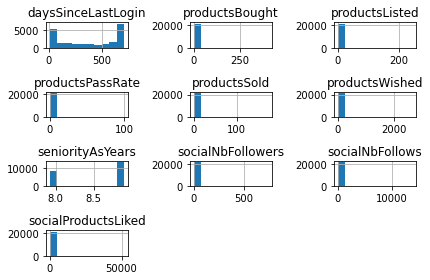

In [31]:
# Histograms
# sns.set(rc={'figure.figsize': (16,3)})

ax = active_clean[ac_numeric_vars].hist(bins=10)
plt.tight_layout()

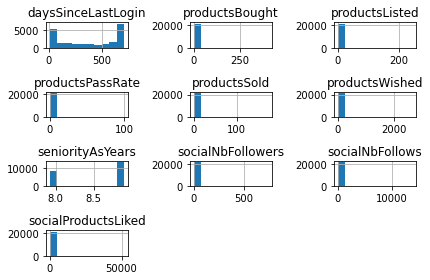

In [32]:
ax = active_clean[ac_numeric_vars].hist(bins=10)
plt.tight_layout()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Text major ticklabel objects>)

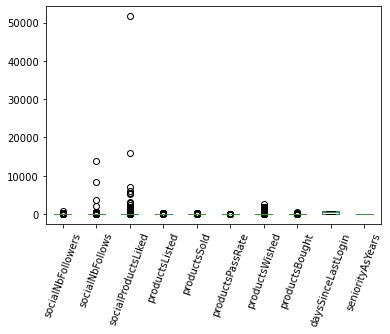

In [33]:
# Boxplots - visualize the minimum, 
#first quartile, median, third quartile, and maximum

active_clean[ac_numeric_vars].plot(kind='box')
plt.xticks(rotation=70)

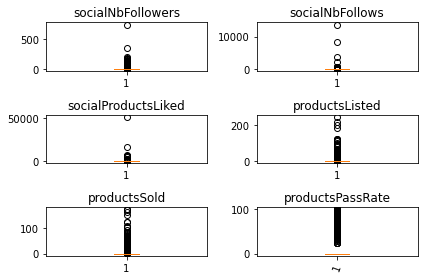

In [34]:
# To better visualize the boxplots, let's plot them one at a time.
fig, axes = plt.subplots(3,2)
for ax, var in zip(axes.ravel(), ac_numeric_vars):
    ax.boxplot(active_clean[var])
    ax.set_title(var)
    plt.xticks(rotation=70)
plt.tight_layout()

# Univariate-Categorical Visualizations

# Numeric vs Numeric Viz

/Users/jonathanayala/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


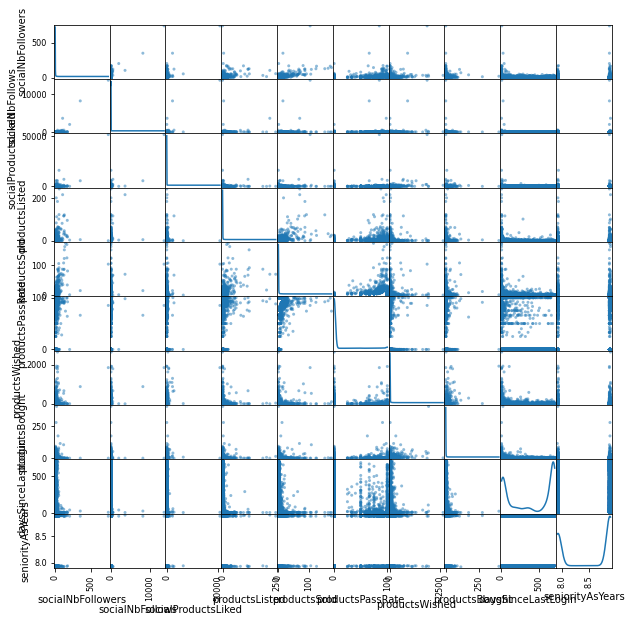

In [35]:
# Scatterplot matrix
from pandas.plotting import scatter_matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = scatter_matrix(active_clean[ac_numeric_vars], ax=ax, diagonal='kde')

In [36]:
# Creating new df w/ only the numerical vars
num_df = active_clean[['socialNbFollowers', 'socialNbFollows',
                  'socialProductsLiked', 'productsListed', 'productsSold',
                  'productsPassRate', 'productsWished', 'productsBought', 
                   'daysSinceLastLogin', 'seniorityAsYears']]
num_df

,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,daysSinceLastLogin,seniorityAsYears
0,147,10,77,26,174,74.0,104,1,11,8.88
1,167,8,2,19,170,99.0,0,0,12,8.90
2,137,13,60,33,163,94.0,10,3,11,8.90
3,131,10,14,122,152,92.0,7,0,12,8.88
4,167,8,0,25,125,100.0,0,0,22,7.93
...,...,...,...,...,...,...,...,...,...,...
21634,3,8,1,0,0,0.0,4,0,477,8.90
21635,3,8,10,0,0,0.0,0,0,15,8.90
21636,3,8,5,0,0,0.0,2,5,192,8.90
21637,3,8,31,0,0,0.0,0,0,13,8.90


The scatterplot matrix makes it difficult to find related elements when there are so many. Let's use a correlation matrix!

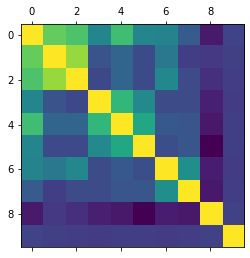

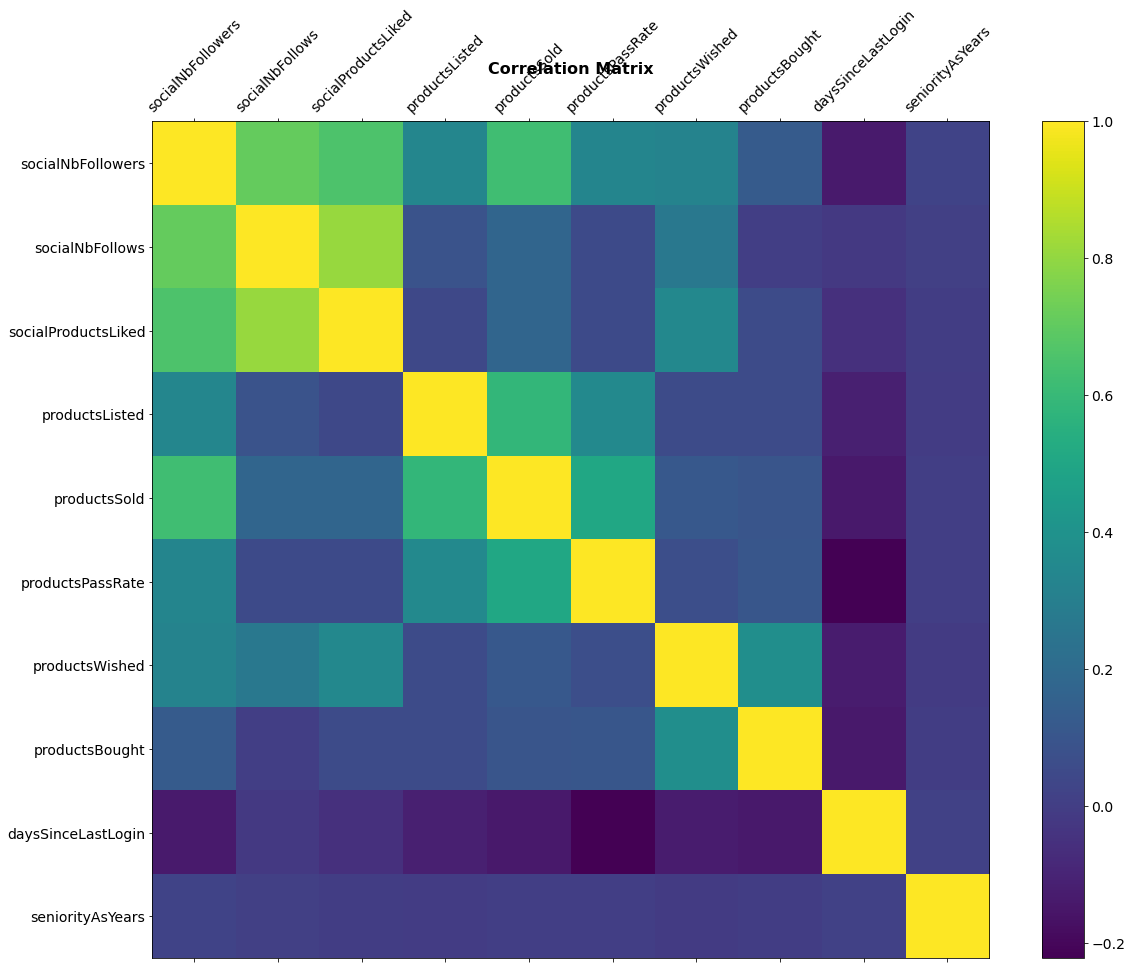

In [37]:
# Correlation Matrix

plt.matshow(num_df.corr())

f = plt.figure(figsize=(19, 15))
plt.matshow(num_df.corr(), fignum=f.number)
plt.xticks(range(num_df.shape[1]), num_df.columns, fontsize=14, rotation=45)
plt.yticks(range(num_df.shape[1]), num_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')

plt.show()

In [38]:
# sellers

In [39]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eng_country          70 non-null     object 
 1   sex                  72 non-null     object 
 2   nbsellers            73 non-null     int64  
 3   meanproductssold     73 non-null     float64
 4   meanproductslisted   73 non-null     float64
 5   meansellerpassrate   73 non-null     float64
 6   totalproductssold    73 non-null     int64  
 7   totalproductslisted  73 non-null     int64  
 8   meanproductsbought   73 non-null     float64
 9   meanproductswished   73 non-null     float64
 10  meanproductsliked    73 non-null     float64
 11  totalbought          73 non-null     int64  
 12  totalwished          73 non-null     int64  
 13  totalproductsliked   73 non-null     int64  
 14  meanfollowers        73 non-null     float64
 15  meanfollows          73 non-null     float

In [40]:
sellers.describe()

,nbsellers,meanproductssold,meanproductslisted,meansellerpassrate,totalproductssold,totalproductslisted,meanproductsbought,meanproductswished,meanproductsliked,totalbought,totalwished,totalproductsliked,meanfollowers,meanfollows,percentofappusers,percentofiosusers,meanseniority
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,66.000000,65.000000,73.000000
mean,111.739726,4.984110,4.177671,26.382329,494.260274,379.273973,3.266575,40.527397,72.186986,225.616438,1874.424658,6601.931507,12.583562,16.475342,68.015152,61.492308,3070.617187
std,412.253126,8.091924,7.484078,21.453931,1809.983142,1410.134078,5.211880,113.551020,134.051376,824.771679,7067.534787,26250.135826,12.190946,25.093557,19.716836,22.041242,100.929973
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,8.000000,20.000000,12.000000,2855.000000
25%,2.000000,1.200000,1.000000,0.000000,3.000000,3.000000,0.000000,1.130000,6.330000,0.000000,4.000000,15.000000,7.500000,8.200000,57.500000,50.000000,3043.909091
50%,5.000000,2.790000,2.250000,29.460000,24.000000,14.000000,1.290000,7.000000,27.750000,15.000000,80.000000,333.000000,9.500000,9.000000,66.000000,57.000000,3084.600000
75%,22.000000,5.250000,4.150000,37.000000,107.000000,82.000000,3.330000,26.400000,69.990000,77.000000,817.000000,1081.000000,13.400000,12.300000,75.000000,66.000000,3130.600000
max,2719.000000,57.000000,56.000000,98.000000,12027.000000,9229.000000,24.670000,707.000000,792.000000,5490.000000,45611.000000,160647.000000,83.000000,157.000000,100.000000,100.000000,3204.000000


In [41]:
s_numeric_vars = []
s_categorical_vars = []

In [ ]:
# topsellers

In [42]:
topsellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   eng_country             19 non-null     object 
 1   sellers                 19 non-null     int64  
 2   topsellers              19 non-null     int64  
 3   topsellerratio          19 non-null     float64
 4   femalesellersratio      19 non-null     float64
 5   topfemalesellersratio   19 non-null     float64
 6   femalesellers           19 non-null     int64  
 7   malesellers             19 non-null     int64  
 8   topfemalesellers        19 non-null     int64  
 9   topmalesellers          19 non-null     int64  
 10  countrysoldratio        19 non-null     float64
 11  bestsoldratio           18 non-null     float64
 12  toptotalproductssold    19 non-null     int64  
 13  totalproductssold       19 non-null     int64  
 14  toptotalproductslisted  19 non-null     int6

In [43]:
topsellers.describe()

,sellers,topsellers,topsellerratio,femalesellersratio,topfemalesellersratio,femalesellers,malesellers,topfemalesellers,topmalesellers,countrysoldratio,bestsoldratio,toptotalproductssold,totalproductssold,toptotalproductslisted,totalproductslisted,topmeanproductssold,topmeanproductslisted,meanproductssold,meanproductslisted,meanofflinedays,topmeanofflinedays,meanfollowers,meanfollowing,topmeanfollowers,topmeanfollowing
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,18.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,99.578947,6.631579,20.968421,78.778947,80.963158,75.368421,24.210526,5.105263,1.526316,2.032632,1.960556,309.105263,610.631579,196.157895,401.157895,50.026688,30.124714,12.966926,8.582865,122.631579,23.757895,19.752632,17.389474,55.310526,56.389474
std,178.948570,9.804820,24.430174,22.167182,26.052025,131.976097,47.390317,7.194865,2.874571,1.616621,1.839704,419.088415,933.298524,296.793281,645.312092,34.374679,19.263995,13.502800,12.208144,73.153940,20.889453,17.128448,14.551552,36.883012,103.303425
min,1.000000,1.000000,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.690000,0.620000,20.000000,28.000000,0.000000,8.000000,20.000000,0.000000,3.722222,1.142857,11.000000,11.000000,7.000000,8.000000,15.000000,3.000000
25%,6.000000,1.000000,6.450000,74.300000,71.800000,5.500000,0.500000,1.000000,0.000000,1.230000,1.267500,44.000000,62.000000,31.000000,46.000000,28.500000,18.500000,5.167766,2.930594,62.600000,11.000000,10.800000,8.700000,36.650000,8.550000
50%,13.000000,2.000000,10.100000,78.700000,85.700000,10.000000,3.000000,1.000000,1.000000,1.590000,1.425000,81.000000,170.000000,56.000000,81.000000,41.000000,21.380952,8.126801,5.500000,121.600000,12.700000,15.100000,10.200000,46.300000,14.500000
75%,112.000000,5.500000,22.500000,92.850000,100.000000,88.000000,24.000000,4.500000,1.000000,2.015000,2.080000,420.000000,751.500000,228.500000,429.000000,56.700000,39.500000,14.000000,7.109375,172.800000,28.500000,20.400000,19.750000,58.300000,36.500000
max,713.000000,35.000000,100.000000,100.000000,100.000000,523.000000,190.000000,23.000000,12.000000,7.310000,8.950000,1389.000000,3014.000000,1077.000000,2218.000000,170.000000,71.333333,57.000000,56.000000,266.100000,79.400000,83.000000,54.600000,167.000000,429.300000


In [ ]:
ts_numeric_vars = []
ts_categorical_vars = [] 

# Findings